LOADING DEPENDENCIES

In [19]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import (
    train_test_split,
    cross_val_score, 
    GridSearchCV)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import (
    LinearRegression,
    LogisticRegression,
    LogisticRegressionCV,
    Lasso,
    Ridge,
    ElasticNet
)
from sklearn.metrics import (
    mean_squared_error,
    mean_absolute_error,
    median_absolute_error,
    mean_absolute_percentage_error,
    r2_score,
    make_scorer,
    accuracy_score, 
    classification_report
)
from sklearn.dummy import DummyRegressor
from sklearn.model_selection import (
    KFold,
    ShuffleSplit,
    cross_val_score,
    cross_validate,
    RandomizedSearchCV,
    GridSearchCV
)
from sklearn import metrics
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import statsmodels.api as sm
import statsmodels.formula.api as smf
from imblearn.over_sampling import SMOTE
from collections import Counter
from tqdm import tqdm
import scipy.stats as sc
from scipy.stats import uniform
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

LOADING DATA

In [20]:
x_train_full=pd.read_csv("data/output/train_full.csv")
x_train=pd.read_csv("data/output/train.csv")
x_test=pd.read_csv("data/output/test.csv")
x_val=pd.read_csv("data/output/validation.csv")


y_train_full=pd.read_csv("data/output/target_train_full.csv")
y_train=pd.read_csv("data/output/target_train.csv")
y_test=pd.read_csv("data/output/target_test.csv")
y_val=pd.read_csv("data/output/target_validation.csv")

df_train=pd.read_csv("data/output/train_with_target.csv")
df_test=pd.read_csv("data/output/test_with_target.csv")

x_train_17=pd.read_csv("data/output/train_logistic.csv")
x_test_17=pd.read_csv("data/output/test_logistic.csv")
x_val_17=pd.read_csv("data/output/validation_logistic.csv")

Firstly, we will analyse the models for all variables (ergo: without tuning applied in logistic regression)

1) KNN

In [24]:
#scaling the datasets 
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_scaled= scaler.fit_transform(x_train)
x_val_scaled=scaler.fit_transform(x_val)
x_test_scaled = scaler.fit_transform(x_test)

In [25]:
# Basic KNN
knn = KNeighborsClassifier(n_neighbors=20, weights="uniform", metric='euclidean')
knn.fit(x_train_scaled, y_train.Satisfaction)
knn_val_pred = knn.predict(x_val_scaled)
print(f"Basic KNN Accuracy: {accuracy_score(y_val.Satisfaction, knn_val_pred):.4f}") #better accuracy than for logistic regression

Basic KNN Accuracy: 0.9228


In [26]:
# Hyperparameter tuning
knn_param_grid = {
    'n_neighbors': [5, 11, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(x_train_scaled, y_train.Satisfaction)
knn_grid_val_pred = knn_grid_search.predict(x_val_scaled)

print(f"Tuned KNN Accuracy: {accuracy_score(y_val.Satisfaction, knn_grid_val_pred):.4f}") 
print("\nKNN Grid Search Results:")
print(f"Best parameters: {knn_grid_search.best_params_}")
print(f"Best cross-validation accuracy: {knn_grid_search.best_score_:.4f}") 

best_knn = knn_grid_search.best_estimator_ 

Tuned KNN Accuracy: 0.9343

KNN Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation accuracy: 0.9379


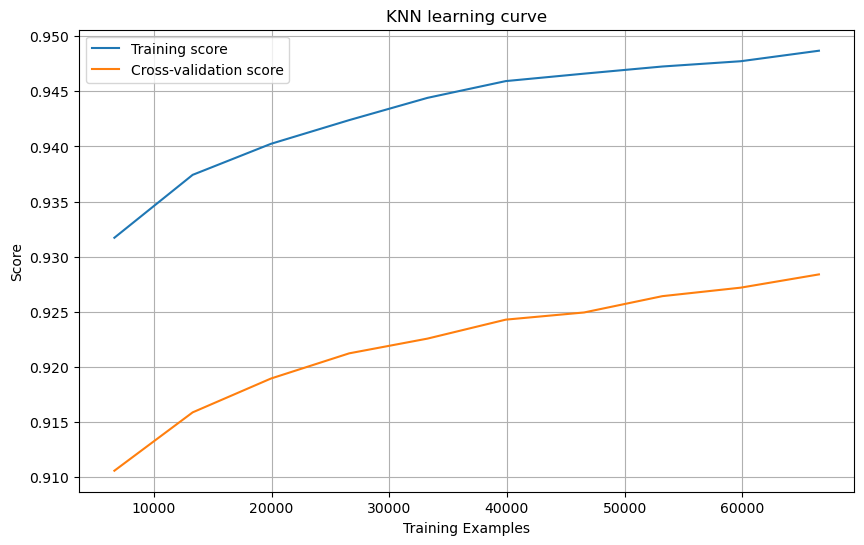

In [27]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curve(KNeighborsClassifier(), x_train_scaled, y_train, "KNN learning curve")

2) Decision Tree

In [28]:
# Basic Decision Tree
dt = DecisionTreeClassifier(random_state=123, max_depth=10)
dt.fit(x_train_scaled, y_train.Satisfaction)
dt_val_pred = dt.predict(x_val_scaled)
print(f"Basic Decision Tree Accuracy: {accuracy_score(y_val.Satisfaction, dt_val_pred):.4f}") 

Basic Decision Tree Accuracy: 0.9425


In [29]:
# Hyperparameter tuning
dt_param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(x_train_scaled, y_train.Satisfaction)
dt_grid_val_pred = dt_grid_search.predict(x_val_scaled)

print(f"Tuned DT Accuracy: {accuracy_score(y_val.Satisfaction, dt_grid_val_pred):.4f}") 

print("\nDecision Tree Grid Search Results:") 
print(f"Best parameters: {dt_grid_search.best_params_}") 
print(f"Best cross-validation accuracy: {dt_grid_search.best_score_:.4f}")

best_dt = dt_grid_search.best_estimator_

Tuned DT Accuracy: 0.9428

Decision Tree Grid Search Results:
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 5}
Best cross-validation accuracy: 0.9445


3) Random Forest

In [30]:
# Basic Random Forest
rf = RandomForestClassifier(random_state=123, n_estimators=10, max_depth=15)
rf.fit(x_train_scaled, y_train.Satisfaction)
rf_val_pred = rf.predict(x_val_scaled)
print(f"Basic Random Forest Accuracy: {accuracy_score(y_val, rf_val_pred):.4f}")

Basic Random Forest Accuracy: 0.9537


In [31]:
# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(x_train_scaled, y_train.Satisfaction)
rf_grid_val_pred = rf_grid_search.predict(x_val_scaled)

print(f"Tuned RF Accuracy: {accuracy_score(y_val.Satisfaction, rf_grid_val_pred):.4f}") 
print("\nRandom Forest Grid Search Results:")
print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation accuracy: {rf_grid_search.best_score_:.4f}")

best_rf = rf_grid_search.best_estimator_

Tuned RF Accuracy: 0.9564

Random Forest Grid Search Results:
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy: 0.9590


FINAL MODEL COMPARISON

In [32]:
#Importing logistic regression
lr = LogisticRegression(penalty=None)
print(x_train_scaled)

[[-0.9844217   0.47082738 -1.49296867 ... -0.44763458  0.45036545
   0.6983944 ]
 [ 1.01582482  0.47082738  0.66980642 ... -0.44763458  1.17194419
   0.7646354 ]
 [-0.9844217   0.47082738  0.66980642 ... -0.44763458 -0.47619884
  -0.03025683]
 ...
 [-0.9844217   0.47082738  0.66980642 ...  0.88156238  1.0003061
   0.49967134]
 [ 1.01582482  0.47082738  0.66980642 ... -0.44763458  1.69868397
   0.8308764 ]
 [-0.9844217   0.47082738  0.66980642 ... -0.44763458  1.69756047
   1.2945635 ]]


In [35]:
# Create dictionary of best models
models = {
    'Logistic Regression': lr,
    'KNN': best_knn,
    'Decision Tree': best_dt,
    'Random Forest': best_rf
}

# Compare models on test set
results = {}

for name, model in models.items():
    # Make predictions on test set
    model = model.fit(x_train_scaled, y_train.Satisfaction)
    y_pred = model.predict(x_test_scaled)
    accuracy = accuracy_score(y_test.Satisfaction, y_pred)
    results[name] = accuracy

    print(f"\n{name} Final Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test.Satisfaction, y_pred))


Logistic Regression Final Test Results:
Accuracy: 0.8736

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14662
           1       0.87      0.83      0.85     11314

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976


KNN Final Test Results:
Accuracy: 0.9372

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14662
           1       0.95      0.90      0.93     11314

    accuracy                           0.94     25976
   macro avg       0.94      0.93      0.94     25976
weighted avg       0.94      0.94      0.94     25976


Decision Tree Final Test Results:
Accuracy: 0.9436

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95     14662
           1 

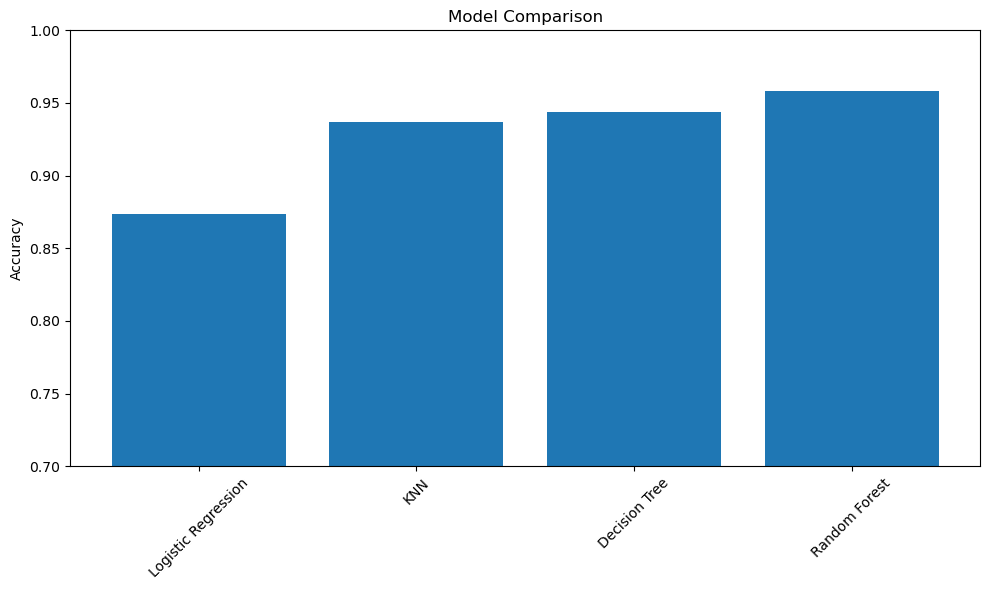

In [36]:
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() #Random Foresr with the highest value of accuracy

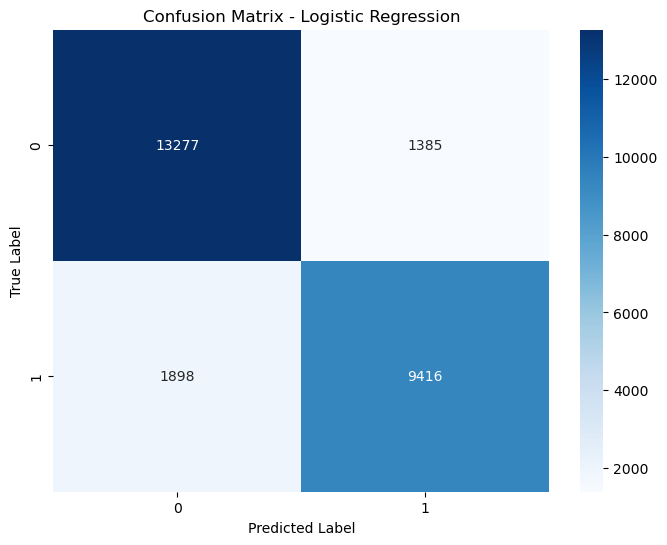

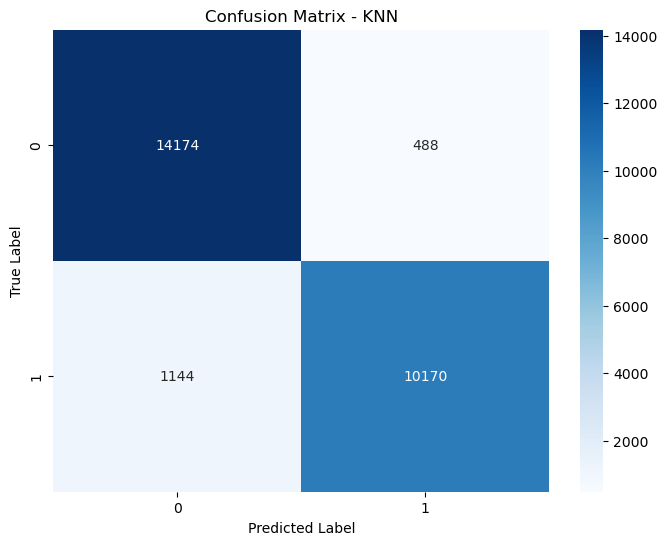

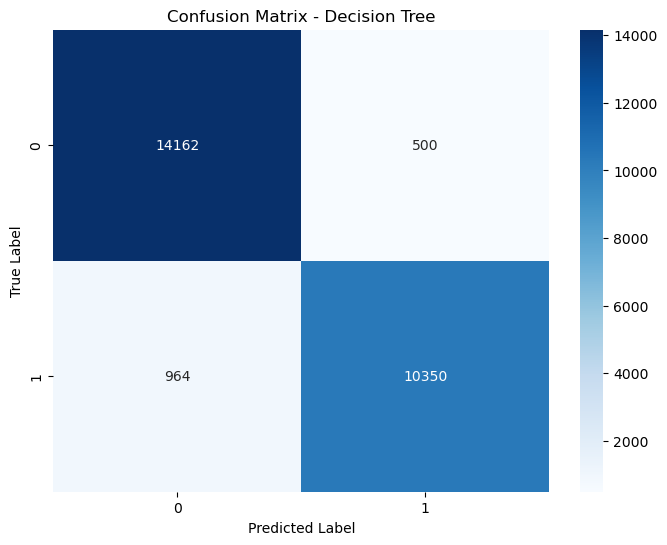

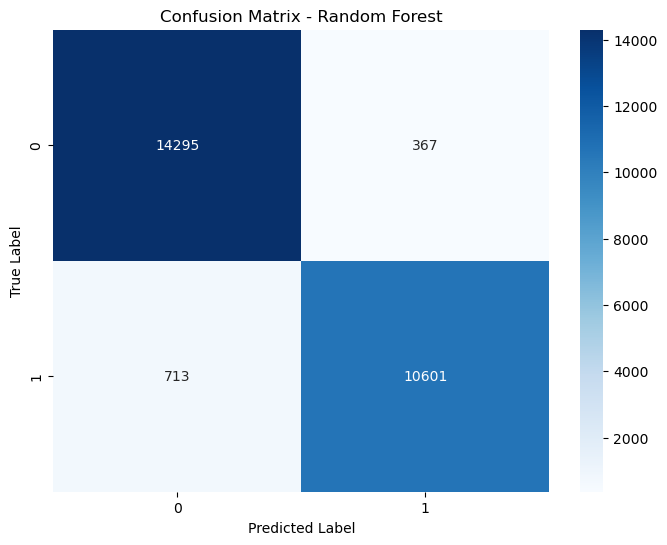

In [37]:
#Matrix that shows [TN, FN, FP, TP] for each model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


for name, model in models.items():
    y_pred = model.predict(x_test_scaled)
    plot_confusion_matrix(y_test.Satisfaction, y_pred, f'Confusion Matrix - {name}')

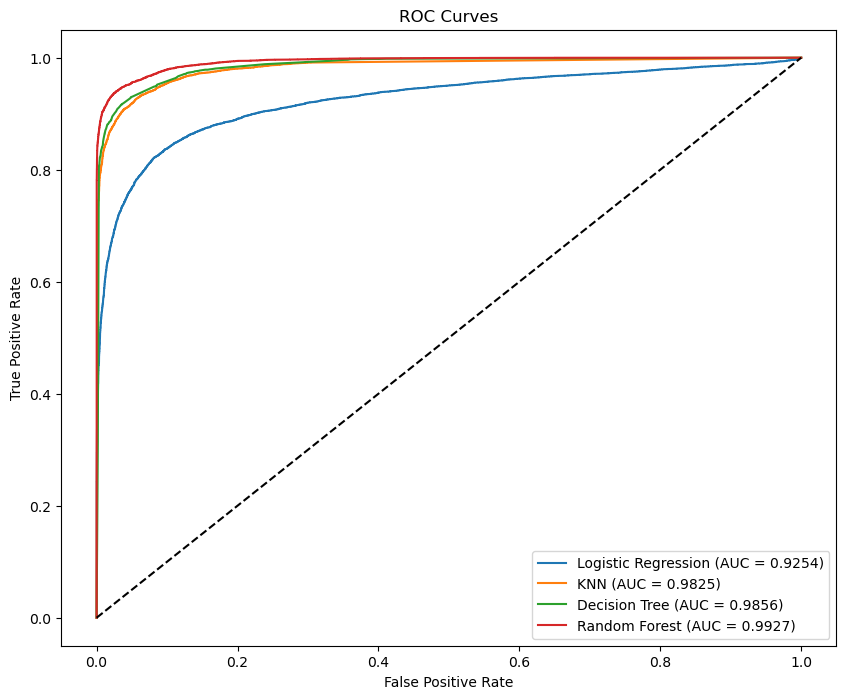

In [38]:
#Plot of ROC Curve for each model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, model in models.items():
  if name not in ("SVM"):
    y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

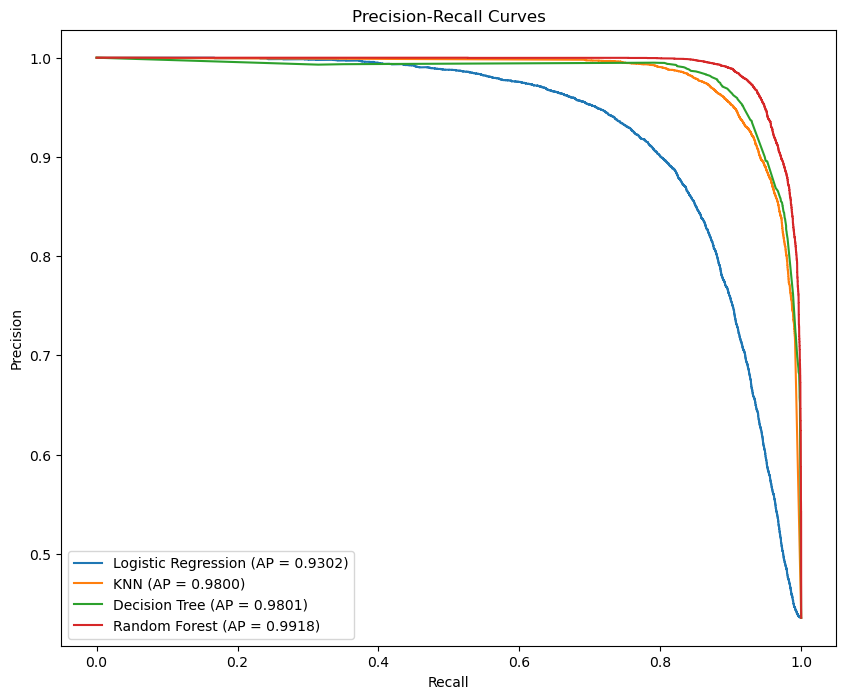

In [39]:
#Plot of Precision-Recall curve for each model
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name not in ("SVM"):
      y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
      precision, recall, _ = precision_recall_curve(y_test.Satisfaction, y_pred_proba)
      avg_precision = average_precision_score(y_test.Satisfaction, y_pred_proba)
      plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()


Now, let's compare same models for selected in previous notebook features

1. KNN

In [40]:
#scaling the datasets 
scaler = StandardScaler(copy=True, with_mean=True, with_std=True)
x_train_scaled= scaler.fit_transform(x_train_17)
x_val_scaled=scaler.fit_transform(x_val_17)
x_test_scaled = scaler.fit_transform(x_test_17)

In [41]:
# Basic KNN
knn = KNeighborsClassifier(n_neighbors=20, weights="uniform", metric='euclidean')
knn.fit(x_train_scaled, y_train.Satisfaction)
knn_val_pred = knn.predict(x_val_scaled)
print(f"Basic KNN Accuracy: {accuracy_score(y_val.Satisfaction, knn_val_pred):.4f}") #better accuracy than for KNN with all variables

Basic KNN Accuracy: 0.9287


In [42]:
# Hyperparameter tuning
knn_param_grid = {
    'n_neighbors': [5, 11, 20],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

knn_grid_search = GridSearchCV(KNeighborsClassifier(), knn_param_grid, cv=5, scoring='accuracy')
knn_grid_search.fit(x_train_scaled, y_train.Satisfaction)
knn_grid_val_pred = knn_grid_search.predict(x_val_scaled)

print(f"Tuned KNN Accuracy: {accuracy_score(y_val.Satisfaction, knn_grid_val_pred):.4f}") 
print("\nKNN Grid Search Results:")
print(f"Best parameters: {knn_grid_search.best_params_}")
print(f"Best cross-validation accuracy: {knn_grid_search.best_score_:.4f}") 

best_knn = knn_grid_search.best_estimator_ #same optimal hyperparameters, better accuracy

Tuned KNN Accuracy: 0.9404

KNN Grid Search Results:
Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best cross-validation accuracy: 0.9416


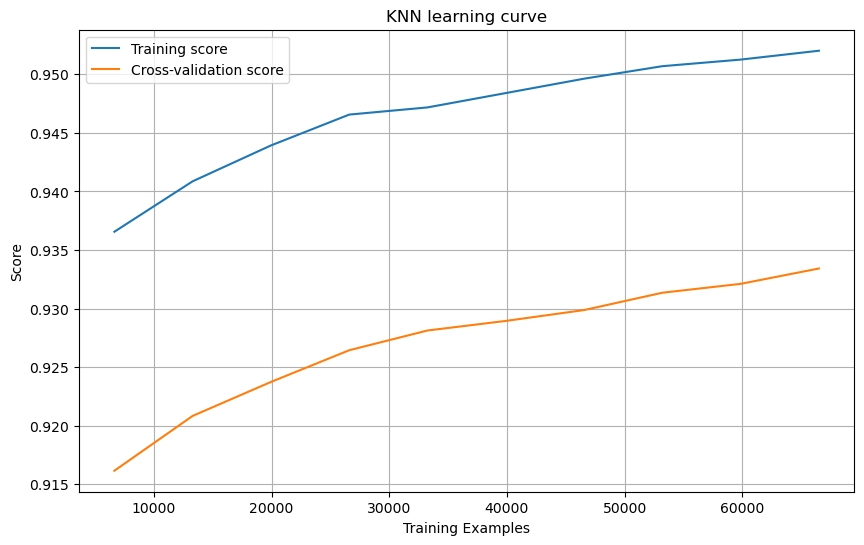

In [43]:
from sklearn.model_selection import learning_curve

def plot_learning_curve(estimator, X, y, title):
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=5, n_jobs=-1,
        train_sizes=np.linspace(0.1, 1.0, 10))

    plt.figure(figsize=(10, 6))
    plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training score')
    plt.plot(train_sizes, np.mean(test_scores, axis=1), label='Cross-validation score')
    plt.title(title)
    plt.xlabel('Training Examples')
    plt.ylabel('Score')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

plot_learning_curve(KNeighborsClassifier(), x_train_scaled, y_train, "KNN learning curve")

2. Decision Tree

In [44]:
# Basic Decision Tree
dt = DecisionTreeClassifier(random_state=123, max_depth=10)
dt.fit(x_train_scaled, y_train.Satisfaction)
dt_val_pred = dt.predict(x_val_scaled)
print(f"Basic Decision Tree Accuracy: {accuracy_score(y_val.Satisfaction, dt_val_pred):.4f}") #decreased accuracy

Basic Decision Tree Accuracy: 0.9407


In [45]:
# Hyperparameter tuning
dt_param_grid = {
    'max_depth': [5, 7, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

dt_grid_search = GridSearchCV(DecisionTreeClassifier(random_state=123), dt_param_grid, cv=5, scoring='accuracy')
dt_grid_search.fit(x_train_scaled, y_train.Satisfaction)
dt_grid_val_pred = dt_grid_search.predict(x_val_scaled)

print(f"Tuned DT Accuracy: {accuracy_score(y_val.Satisfaction, dt_grid_val_pred):.4f}") 

print("\nDecision Tree Grid Search Results:") 
print(f"Best parameters: {dt_grid_search.best_params_}") 
print(f"Best cross-validation accuracy: {dt_grid_search.best_score_:.4f}")

best_dt = dt_grid_search.best_estimator_ #more number of min_samples_split hyperparameter

Tuned DT Accuracy: 0.9409

Decision Tree Grid Search Results:
Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10}
Best cross-validation accuracy: 0.9438


3. Random Forest

In [46]:
# Basic Random Forest
rf = RandomForestClassifier(random_state=123, n_estimators=10, max_depth=15)
rf.fit(x_train_scaled, y_train.Satisfaction)
rf_val_pred = rf.predict(x_val_scaled)
print(f"Basic Random Forest Accuracy: {accuracy_score(y_val, rf_val_pred):.4f}") #increased accuracy

Basic Random Forest Accuracy: 0.9561


In [47]:
# Hyperparameter tuning
rf_param_grid = {
    'n_estimators': [10, 20, 50],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf_grid_search = GridSearchCV(RandomForestClassifier(random_state=123), rf_param_grid, cv=5, scoring='accuracy')
rf_grid_search.fit(x_train_scaled, y_train.Satisfaction)
rf_grid_val_pred = rf_grid_search.predict(x_val_scaled)

print(f"Tuned RF Accuracy: {accuracy_score(y_val.Satisfaction, rf_grid_val_pred):.4f}") 
print("\nRandom Forest Grid Search Results:")
print(f"Best parameters: {rf_grid_search.best_params_}")
print(f"Best cross-validation accuracy: {rf_grid_search.best_score_:.4f}")

best_rf = rf_grid_search.best_estimator_ #same optimal hyperparameters, better accuracy

Tuned RF Accuracy: 0.9582

Random Forest Grid Search Results:
Best parameters: {'max_depth': 15, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best cross-validation accuracy: 0.9604


FINAL MODEL COMPARISON

In [48]:
#Importing logistic regression
lr = LogisticRegression(penalty=None)
print(x_train_scaled)

[[ 0.47082738 -1.49296867 -1.07085284 ...  0.31284198  0.45036545
   0.6983944 ]
 [ 0.47082738  0.66980642  1.00708213 ...  0.31284198  1.17194419
   0.7646354 ]
 [ 0.47082738  0.66980642  1.00708213 ... -0.53189438 -0.47619884
  -0.03025683]
 ...
 [ 0.47082738  0.66980642  1.00708213 ...  0.31284198  1.0003061
   0.49967134]
 [ 0.47082738  0.66980642  1.00708213 ...  1.15757834  1.69868397
   0.8308764 ]
 [ 0.47082738  0.66980642  1.00708213 ... -1.37663073  1.69756047
   1.2945635 ]]


In [49]:
# Create dictionary of best models
models = {
    'Logistic Regression': lr,
    'KNN': best_knn,
    'Decision Tree': best_dt,
    'Random Forest': best_rf
}

# Compare models on test set
results = {}

for name, model in models.items():
    # Make predictions on test set
    model = model.fit(x_train_scaled, y_train.Satisfaction)
    y_pred = model.predict(x_test_scaled)
    accuracy = accuracy_score(y_test.Satisfaction, y_pred)
    results[name] = accuracy

    print(f"\n{name} Final Test Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print("\nClassification Report:")
    print(classification_report(y_test.Satisfaction, y_pred))


Logistic Regression Final Test Results:
Accuracy: 0.8719

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.90      0.89     14662
           1       0.87      0.83      0.85     11314

    accuracy                           0.87     25976
   macro avg       0.87      0.87      0.87     25976
weighted avg       0.87      0.87      0.87     25976


KNN Final Test Results:
Accuracy: 0.9404

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14662
           1       0.96      0.90      0.93     11314

    accuracy                           0.94     25976
   macro avg       0.94      0.94      0.94     25976
weighted avg       0.94      0.94      0.94     25976


Decision Tree Final Test Results:
Accuracy: 0.9433

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95     14662
           1 

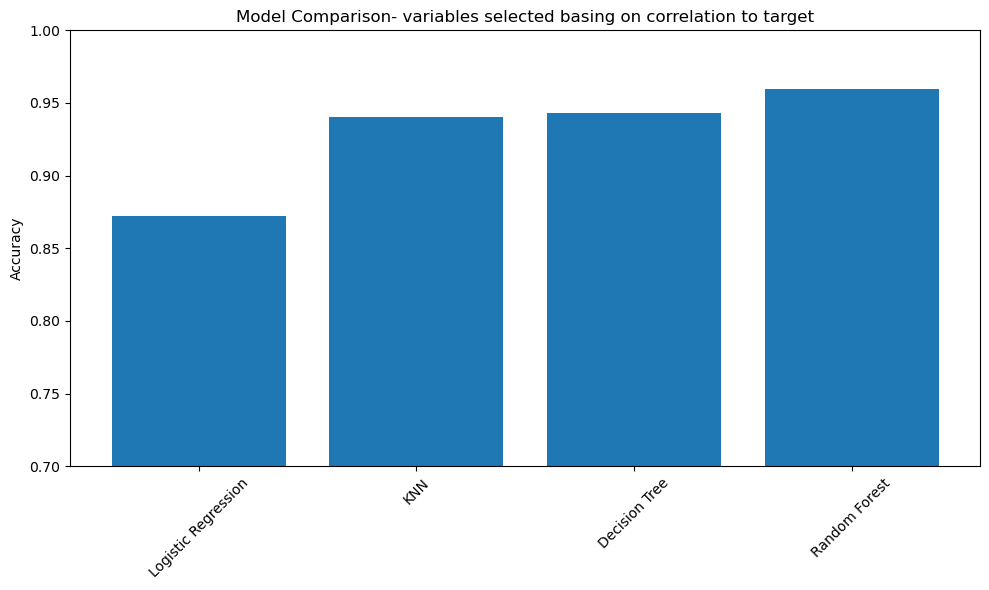

In [50]:
plt.figure(figsize=(10, 6))
plt.bar(results.keys(), results.values())
plt.title('Model Comparison- variables selected basing on correlation to target')
plt.ylabel('Accuracy')
plt.ylim(0.7, 1.0)  
plt.xticks(rotation=45)
plt.tight_layout()
plt.show() #Random Foresr with the highest value of accuracy

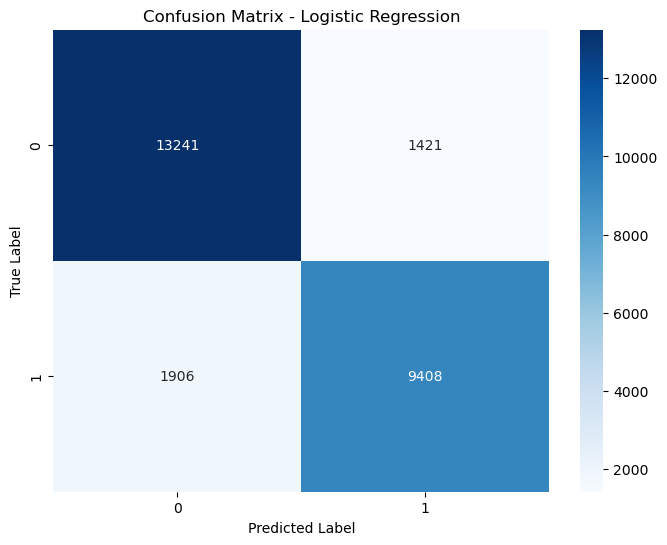

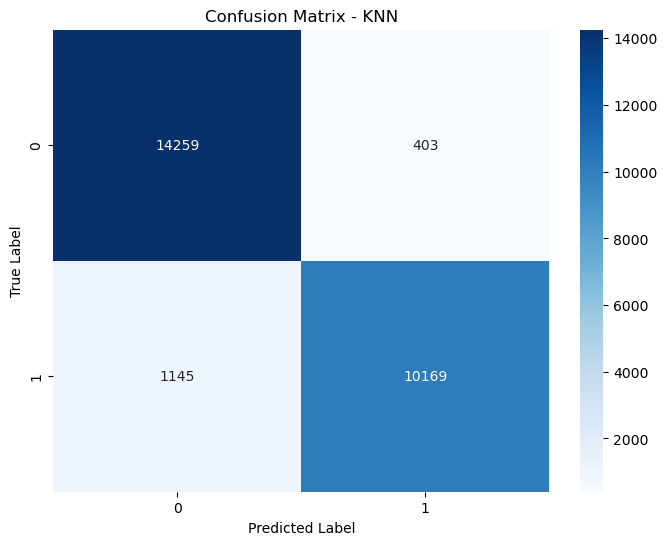

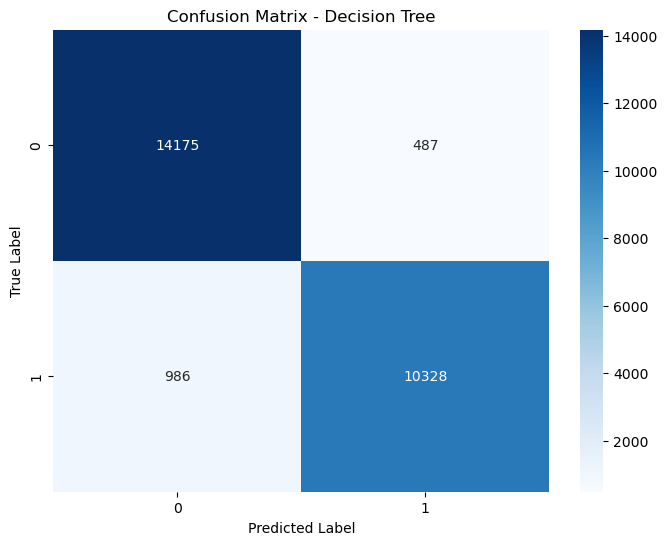

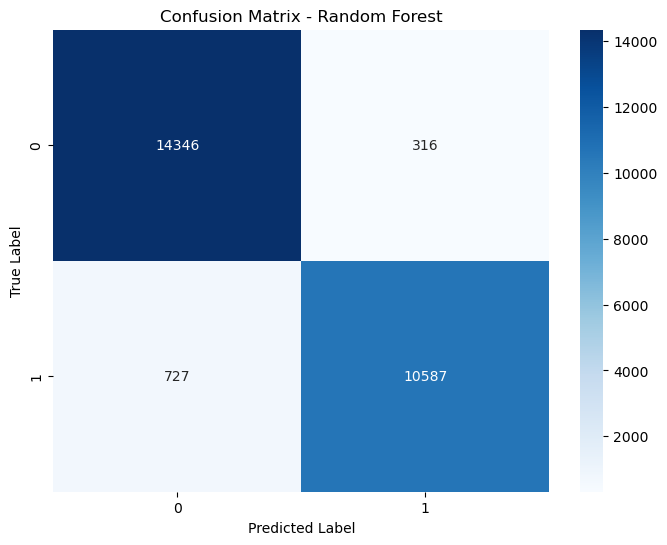

In [51]:
#Matrix that shows [TN, FN, FP, TP] for each model
from sklearn.metrics import confusion_matrix
import seaborn as sns

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


for name, model in models.items():
    y_pred = model.predict(x_test_scaled)
    plot_confusion_matrix(y_test.Satisfaction, y_pred, f'Confusion Matrix - {name}')

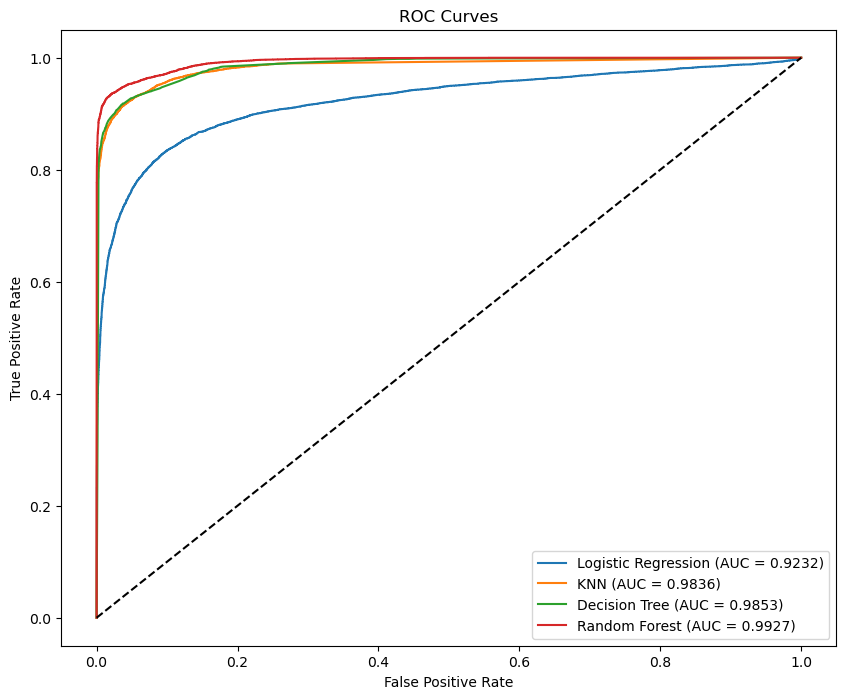

In [52]:
#Plot of ROC Curve for each model
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
for name, model in models.items():
  if name not in ("SVM"):
    y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.4f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

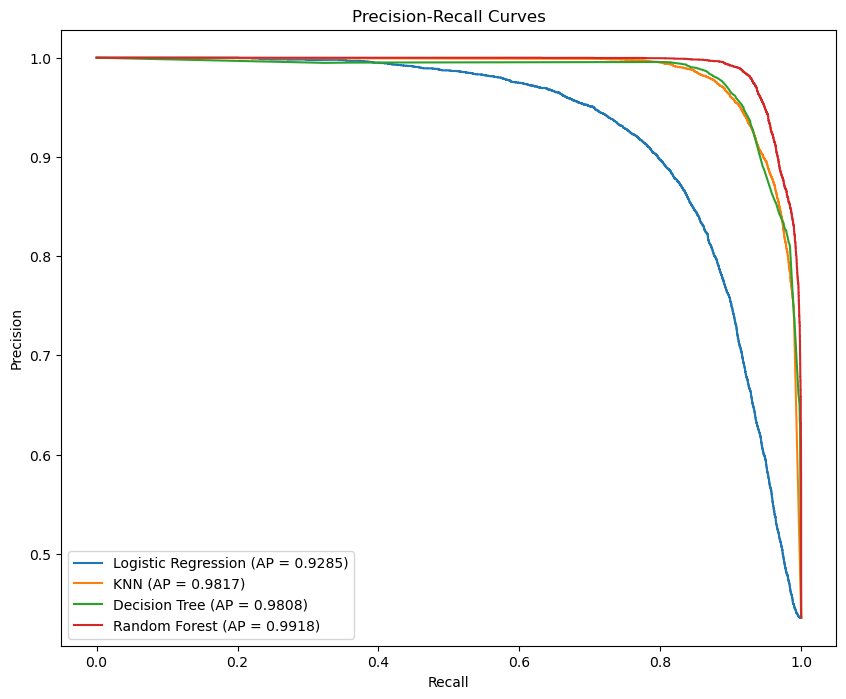

In [53]:
#Plot of Precision-Recall curve for each model
from sklearn.metrics import precision_recall_curve, average_precision_score

plt.figure(figsize=(10, 8))
for name, model in models.items():
    if name not in ("SVM"):
      y_pred_proba = model.predict_proba(x_test_scaled)[:, 1]
      precision, recall, _ = precision_recall_curve(y_test.Satisfaction, y_pred_proba)
      avg_precision = average_precision_score(y_test.Satisfaction, y_pred_proba)
      plt.plot(recall, precision, label=f'{name} (AP = {avg_precision:.4f})')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curves')
plt.legend()
plt.show()


Conclusion: features selection beneficial for KNN and RF but not for Logistic Regression and Decision Tree